In [94]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os
from pathlib import Path
from datetime import datetime

from pyannote.audio import Pipeline
from pyannote.core import json

from matplotlib import pyplot as plt, lines
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src import (
    downsample as downsamp_audio, 
    embedding_extractor as ee, 
    dimension_reducer as dr, 
    distance_metrics as dm, 
    downsample as ds,
    emb_manipulator as em
)

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
emb_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
#files = ['03016_diarized_pyv2.csv','2022_06_01_emb.csv']
files = ['IV_001-020_0316.csv','IV_021-023-BB003_0601.csv','spont_script_all_0606.csv']

emb_unscaled = pd.DataFrame()

for f in files:
    temp = pd.read_csv(os.path.join(emb_dir,f), index_col=0)
    temp['data_set'] = [Path(f).stem]*temp.shape[0]
    emb_unscaled = pd.concat([emb_unscaled,temp], ignore_index=True)

#emb_down_unscaled = em.resample_data(emb,1)

scaler = StandardScaler()
emb = pd.DataFrame(scaler.fit_transform(emb_unscaled.drop(columns=['part_id','data_set'])))
emb['part_id'] = emb_unscaled.part_id.astype('string').to_numpy()
emb['data_set'] = emb_unscaled.data_set.astype('string').to_numpy()

In [134]:
pid = []
sex_list = []
test = []
for name,corpus in zip(emb.part_id, emb.data_set):
    test.append(name)
    if corpus == 'IV_001-020_0316' or corpus == 'IV_021-023-BB003_0601':
        pid.append(name.split("_")[0])
        sex_list.append('F')
    elif corpus == 'spont_script_all_0606':
        pid.append(name.split("_")[0] + "_" + name.split("_")[3])
        sex_list.append(name.split("_")[1])

In [136]:
emb_label_clean = emb.copy()
emb_label_clean['part_id'] = pid
emb_label_clean['sex'] = sex_list

In [3]:
from sklearn.manifold import TSNE
import umap

X= emb.drop(columns=['part_id'])
#metric = 'cosine'
metric = 'euclidean'

tsne = TSNE(n_components=2, init = 'pca', random_state=20, metric=metric)
umap = umap.UMAP(n_components=2,metric=metric)

Xtsne = tsne.fit_transform(X)

#my_tsne_test=dr.run_tsne(emb, init = 'pca', random_state=20, metric='euclidean')

Xumap = umap.fit_transform(X)

[Text(0.5, 1.0, 'tsneeuclidean')]

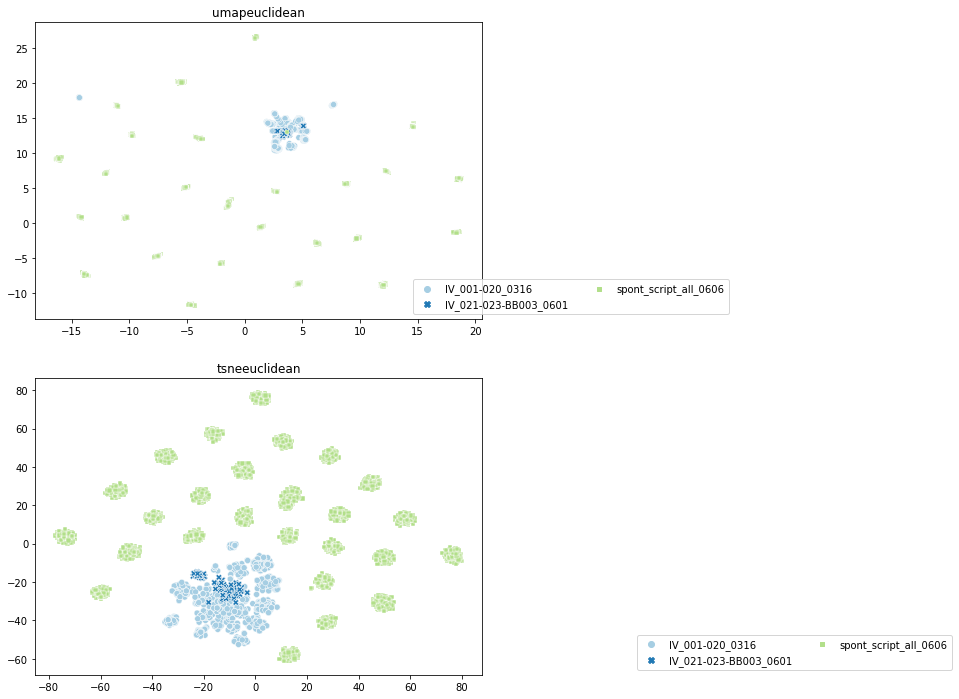

In [138]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))
#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, palette="Paired", hue=emb_label_clean.data_set, style=emb_label_clean.data_set, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_umap.set(title = 'umap' + metric)
#clust_plt_umap.set(title = str(dist.umap))

#clust_plt_my_tsne = sns.scatterplot(x=my_tsne_test.dim0, y=my_tsne_test.dim1, ax=ax1, palette="Paired", hue=emb.part_id, style=emb.part_id)
#ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, palette="Paired", hue=emb_label_clean.data_set, style=emb_label_clean.data_set,legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.7,  0), ncol=2)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

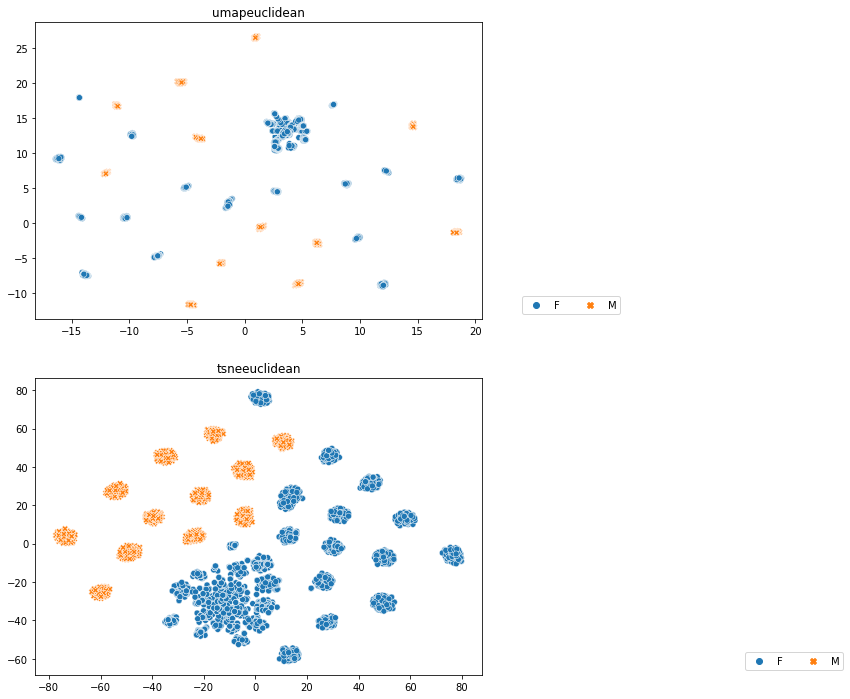

In [139]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))
#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, hue=emb_label_clean.sex, style=emb_label_clean.sex, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_umap.set(title = 'umap' + metric)
#clust_plt_umap.set(title = str(dist.umap))

#clust_plt_my_tsne = sns.scatterplot(x=my_tsne_test.dim0, y=my_tsne_test.dim1, ax=ax1, palette="Paired", hue=emb.part_id, style=emb.part_id)
#ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, hue=emb_label_clean.sex, style=emb_label_clean.sex,legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.7,  0), ncol=2)
clust_plt_tsne.set(title = 'tsne' + metric)

In [146]:
Xumap_df = pd.DataFrame(Xumap, columns=['dim0', 'dim1'])
Xumap_df['part_id'] = emb_label_clean.part_id.to_numpy()
Xtsne_df = pd.DataFrame(Xtsne, columns=['dim0', 'dim1'])
Xtsne_df['part_id'] = emb_label_clean.part_id.to_numpy()


In [147]:
d_umap = dm.hausdorff_distances(Xumap_df)
d_tsne = dm.hausdorff_distances(Xtsne_df)

Processing row 48, col 48


In [148]:
target = 'BB003'
d_umap[target].abs().nlargest(n=6)

062_script    1.718718
053_script    1.580121
4             1.549627
7             1.546410
5             1.518954
10            1.509341
Name: BB003, dtype: float64

In [149]:
d_tsne[target].abs().nlargest(n=6)

071_script    1.554487
051_script    1.444617
6             1.409163
12            1.325377
022           1.267442
13            1.253685
Name: BB003, dtype: float64

In [393]:
d_umap_flat = pd.DataFrame(d_umap.to_numpy().flatten()).dropna()
d_tsne_flat = pd.DataFrame(d_tsne.to_numpy().flatten()).dropna()

d_umap_flat.corrwith(d_tsne_flat)

0    0.360783
dtype: float64

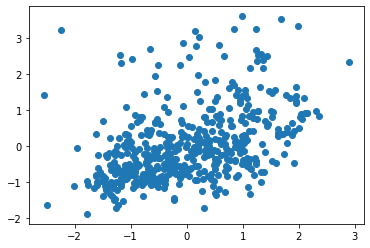

In [382]:
plt.scatter(d_tsne_flat,d_umap_flat)

In [17]:
min_dist=0.1
dim = 2
n_neighbors = 10

#run umap with default parameters
emb_umap = dr.run_umap(emb, n_components=2, n_neighbors=n_neighbors, min_dist=min_dist metric='euclidean')

knn=50
knn_classes=4
subsetsize=700

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb.drop(columns='part_id').to_numpy()
classes= emb.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
#low_dim = emb_tsne.drop(columns='part_id').to_numpy()
#dist_tsne = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#compare umap to embeddings
low_dim = emb_umap.drop(columns='part_id').to_numpy()
dist_umap = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)


#create a dataframe of all distance metrics for each dimension method
#dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap'])
dist = pd.DataFrame(dist_umap, index = ['micro', 'meso', 'macro'], columns= ['umap'])
dist = dist.round(decimals=3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0.5, 1.0, 'micro    0.508\nmeso     0.446\nmacro    0.338\nName: umap, dtype: float64')]

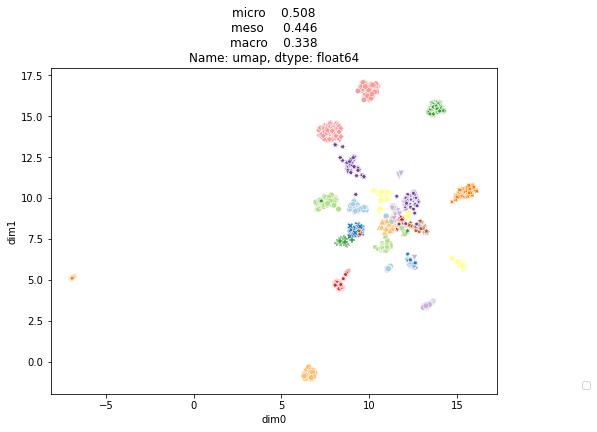

In [29]:
##plot 2 dimensions from each dimension reduction
fig, ax1 = plt.subplots(figsize=(8,6))
#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))


clust_plt_umap = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax1, palette="Paired", hue=emb_umap.part_id, style=emb_umap.part_id, legend=False)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
clust_plt_umap.set(title = str(dist.umap))

#clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax2, palette="Paired", hue=emb_tsne.part_id, style=emb_tsne.part_id)
#ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
#clust_plt_tsne.set(title = str(dist[dist.index=='tsne']))

In [15]:
haus_umap = dm.hausdorff_distances(emb_umap)

Processing row 22, col 22


In [34]:
import librosa

In [57]:
librosa_files_1 = r'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/0300222_recordings_16khz'
librosa_files_2 = r'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/053122_new_participants/audio_16kHz'
wav_files = [os.path.join(librosa_files_1, file) for file in os.listdir(librosa_files_1)]
wav_files.extend([os.path.join(librosa_files_2, file) for file in os.listdir(librosa_files_2)])

In [198]:

wav_data = {Path(wav).stem:librosa.load(wav, sr=16000, mono=True) for wav in wav_files}

In [202]:
## shape/(framelength/4) + 1 = num_embed
## num_embed-1 = shape/(framelength/4)
## 1/(num_embed-1) = (framelength/4)/shape
## shape/(num_embed-1) = framelength/4
## 4 * shape/(num_embed-1) = framelength

frame_length = 4*l//(emb.shape[0]-1)

f0 = {part:librosa.yin(wav[0], 
                  sr=16000,
                  fmin = librosa.note_to_hz('C2'), 
                  fmax= librosa.note_to_hz('C7')) 
      for part,wav in wav_data.items()}

<AxesSubplot:xlabel='dim0', ylabel='dim1'>

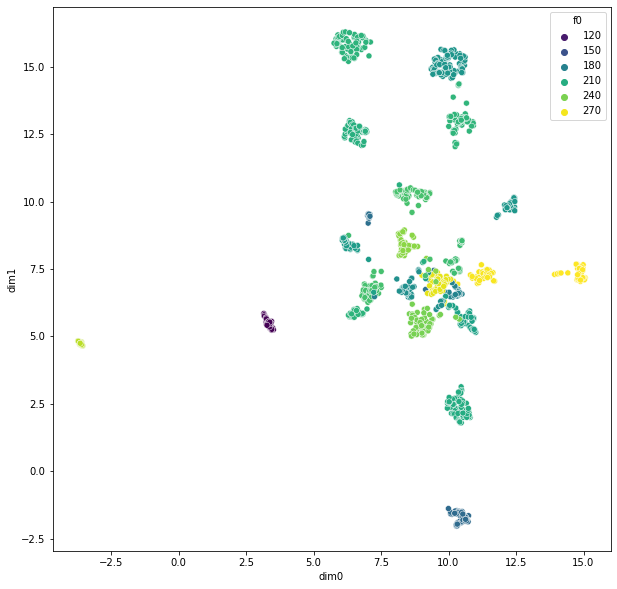

In [288]:
#adding median f0 for each utterance to the plot. I filter out frequencies that seem out of desired range before getting median per part

f_lower_lim_humans=50
f_upper_lim_humans=600

f0_filtered = {part:[x for x in f if x>f_lower_lim_humans if x<f_upper_lim_humans] for part, f in f0.items()}

f0_median = {part:np.median(f) for part,f in f0_filtered.items()}

emb.part_id = [part.zfill(3) for part in emb.part_id.astype('string')]

for wav in wav_files:
    temp = emb[emb.part_id==Path(wav).stem]
    emb.loc[emb.part_id==Path(wav).stem, 'f0'] = f0_median[Path(wav).stem]

#was going to try ot asign a value per embedding but that was just leading to poor extrapolation
#import random
#f0_flat = list(np.concatenate(f0_filtered).flat)
#f0_flat = list(np.repeat(f0_flat,3))

#prune = random.sample(range(1,len(f0_flat)),len(f0_flat)-emb.shape[0])

#for skip in sorted(prune, reverse=True):
#    del f0_flat[skip]
    
#emb['f0'] = f0_flat

fig = plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, hue=emb.f0, palette="viridis")

In [294]:
a = 'a_spont_08'
b = 'b_script_09'
test = [a, b]
test

['a_spont_08', 'b_script_09']

In [298]:
[x for x in test if 'spont' in x]

['a_spont_08']